In [25]:
from copy import deepcopy
from thesis.cemrl.buffer import CemrlReplayBuffer as NewBuffer
from src.cemrl.buffers import CEMRLReplayBuffer as Buffer
from src.envs.toy_goal_env import ToyGoalEnv
from src.envs.samplers import RandomBoxSampler
from src.cemrl.wrappers import CEMRLWrapper
from gymnasium.wrappers.time_limit import TimeLimit
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.sac import SAC
from src.cemrl.networks import Encoder
from thesis.cemrl.task_inference import Encoder as NewEncoder
from thesis.cemrl.config import EncoderConfig
from tqdm import tqdm
import numpy as np
import warnings
warnings.filterwarnings("ignore")

sampler = RandomBoxSampler()
env = DummyVecEnv([lambda: TimeLimit(CEMRLWrapper(ToyGoalEnv(sampler)), 200)] * 101)

encoder = Encoder(1, 2, 2, 2, 40., 1).cuda()
buffer = Buffer(1_000_000, env.observation_space, env.action_space, encoder, n_envs=101, use_bin_weighted_decoder_target_sampling=False)

new_encoder = NewEncoder(2, 2, EncoderConfig()).cuda()
new_buffer = NewBuffer(1_000_000, env.observation_space, env.action_space, 200, 100, n_envs=101)
new_buffer.task_inference = new_encoder # type: ignore

_last_obs = env.reset()
for _ in tqdm(range(1002)):
    action = np.stack([env.action_space.sample() for _ in range(env.num_envs)])
    new_obs, reward, dones, infos = env.step(action)
    

    _last_original_obs, new_obs_, reward_ = _last_obs, new_obs, reward

    # Avoid modification by reference
    next_obs = deepcopy(new_obs_)
    # As the VecEnv resets automatically, new_obs is already the
    # first observation of the next episode
    for i, done in enumerate(dones):
        if done and infos[i].get("terminal_observation") is not None:
            next_obs_ = infos[i]["terminal_observation"]
            # Replace next obs for the correct envs
            for key in next_obs.keys():
                next_obs[key][i] = next_obs_[key]

    buffer.add(_last_original_obs, next_obs, action, reward_, dones, infos)
    new_buffer.add(_last_original_obs, next_obs, action, reward_, dones, infos)

    _last_obs = new_obs




100%|██████████| 1002/1002 [00:09<00:00, 106.68it/s]


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


<Axes: xlabel='done', ylabel='Count'>

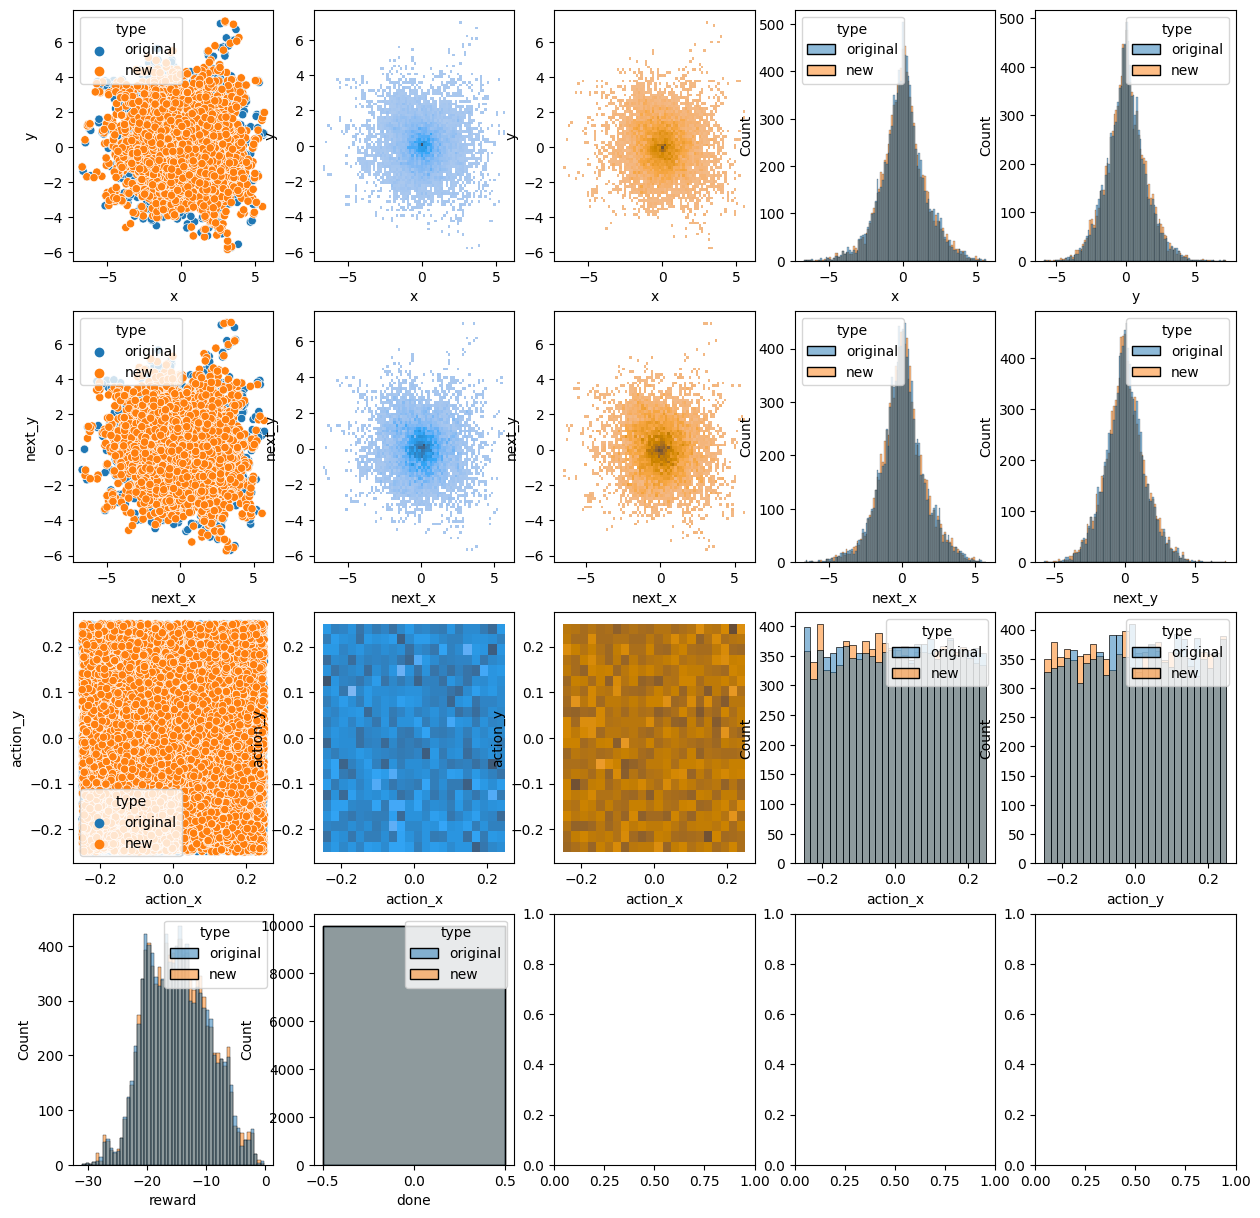

In [27]:
buffer_samples = buffer.sample(10000)
new_buffer_samples = new_buffer.sample(10000)

df_orginal = pd.DataFrame(
    {
        "x": buffer_samples.observations["observation"][:, 0].cpu().numpy(),
        "y": buffer_samples.observations["observation"][:, 1].cpu().numpy(),
        "next_x": buffer_samples.next_observations["observation"][:, 0].cpu().numpy(),
        "next_y": buffer_samples.next_observations["observation"][:, 1].cpu().numpy(),
        "action_x": buffer_samples.actions[:, 0].cpu().numpy(),
        "action_y": buffer_samples.actions[:, 1].cpu().numpy(),
        "reward": buffer_samples.rewards[:, 0].cpu().numpy(),
        "done": buffer_samples.dones[:, 0].cpu().numpy(),
        "type": "original",
    }
)
df_new = pd.DataFrame(
    {
        "x": new_buffer_samples.observations["obs"][:, 0].cpu().numpy(),
        "y": new_buffer_samples.observations["obs"][:, 1].cpu().numpy(),
        "next_x": new_buffer_samples.next_observations["obs"][:, 0].cpu().numpy(),
        "next_y": new_buffer_samples.next_observations["obs"][:, 1].cpu().numpy(),
        "action_x": new_buffer_samples.actions[:, 0].cpu().numpy(),
        "action_y": new_buffer_samples.actions[:, 1].cpu().numpy(),
        "reward": new_buffer_samples.rewards[:, 0].cpu().numpy(),
        "done": new_buffer_samples.dones[:, 0].cpu().numpy(),
        "type": "new",
    }
)

df = pd.concat([df_orginal, df_new])

fig, axs = plt.subplots(4, 5, figsize=(15, 15))
sns.scatterplot(data=df, x="x", y="y", hue="type", ax=axs[0, 0])
sns.histplot(data=df_orginal, x="x", y="y", ax=axs[0, 1])
sns.histplot(data=df_new, x="x", y="y", color="orange", ax=axs[0, 2])
sns.histplot(data=df, x="x", hue="type", ax=axs[0, 3])
sns.histplot(data=df, x="y", hue="type", ax=axs[0, 4])

sns.scatterplot(data=df, x="next_x", y="next_y", hue="type", ax=axs[1, 0])
sns.histplot(data=df_orginal, x="next_x", y="next_y", ax=axs[1, 1])
sns.histplot(data=df_new, x="next_x", y="next_y", color="orange", ax=axs[1, 2])
sns.histplot(data=df, x="next_x", hue="type", ax=axs[1, 3])
sns.histplot(data=df, x="next_y", hue="type", ax=axs[1, 4])

sns.scatterplot(data=df, x="action_x", y="action_y", hue="type", ax=axs[2, 0])
sns.histplot(data=df_orginal, x="action_x", y="action_y", ax=axs[2, 1])
sns.histplot(data=df_new, x="action_x", y="action_y", color="orange", ax=axs[2, 2])
sns.histplot(data=df, x="action_x", hue="type", ax=axs[2, 3])
sns.histplot(data=df, x="action_y", hue="type", ax=axs[2, 4])

sns.histplot(data=df, x="reward", hue="type", ax=axs[3, 0])
sns.histplot(data=df, x="done", hue="type", ax=axs[3, 1])



<Axes: xlabel='goal', ylabel='Count'>

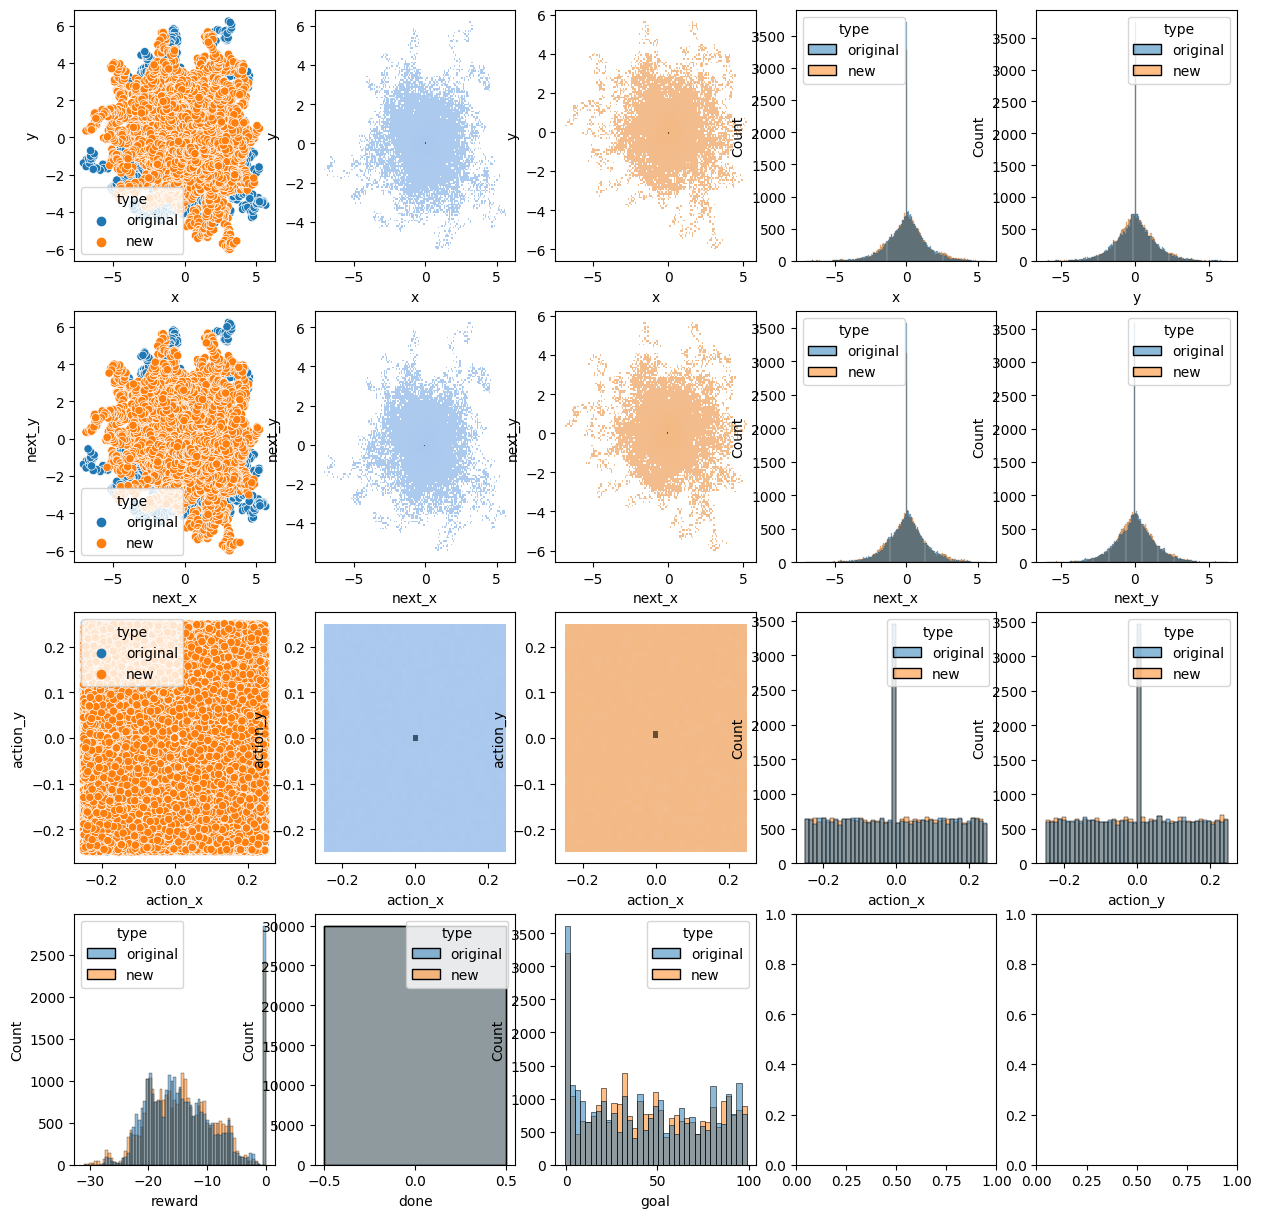

In [28]:
import numpy as np
new_samples, _ = new_buffer.cemrl_sample(1000, decoder_context_length=1)
samples, indices, (batch, time) = buffer.get_encoder_context(np.random.choice(buffer.valid_indices(), 1000), return_indices=True)
goals = buffer.goal_idxs[indices]
goals[(batch.cpu(), time.cpu())] = 0

df_orginal = pd.DataFrame({
    "x": samples.observations.view(-1, 2)[:, 0].cpu(),
    "y": samples.observations.view(-1, 2)[:, 1].cpu(),
    "next_x": samples.next_observations.view(-1, 2)[:, 0].cpu(),
    "next_y": samples.next_observations.view(-1, 2)[:, 1].cpu(),
    "action_x": samples.actions.view(-1, 2)[:, 0].cpu(),
    "action_y": samples.actions.view(-1, 2)[:, 1].cpu(),
    "reward": samples.rewards.view(-1).cpu(),
    "done": samples.dones.view(-1).cpu(),
    "type": "original",
    "goal": goals.reshape(-1),
})

df_new = pd.DataFrame({
    "x": new_samples.observations["observation"].view(-1, 2)[:, 0].cpu(),
    "y": new_samples.observations["observation"].view(-1, 2)[:, 1].cpu(),
    "next_x": new_samples.next_observations["observation"].view(-1, 2)[:, 0].cpu(), 
    "next_y": new_samples.next_observations["observation"].view(-1, 2)[:, 1].cpu(),
    "action_x": new_samples.actions.view(-1, 2)[:, 0].cpu(),
    "action_y": new_samples.actions.view(-1, 2)[:, 1].cpu(),
    "reward": new_samples.rewards.view(-1).cpu(),
    "done": new_samples.dones.view(-1).cpu(),
    "type": "new",
    "goal": new_samples.next_observations["goal_idx"].view(-1).cpu(),
})

df = pd.concat([df_orginal, df_new])

fig, axs = plt.subplots(4, 5, figsize=(15, 15))
sns.scatterplot(data=df, x="x", y="y", hue="type", ax=axs[0, 0])
sns.histplot(data=df_orginal, x="x", y="y", ax=axs[0, 1])
sns.histplot(data=df_new, x="x", y="y", color="orange", ax=axs[0, 2])
sns.histplot(data=df, x="x", hue="type", ax=axs[0, 3])
sns.histplot(data=df, x="y", hue="type", ax=axs[0, 4])

sns.scatterplot(data=df, x="next_x", y="next_y", hue="type", ax=axs[1, 0])
sns.histplot(data=df_orginal, x="next_x", y="next_y", ax=axs[1, 1])
sns.histplot(data=df_new, x="next_x", y="next_y", color="orange", ax=axs[1, 2])
sns.histplot(data=df, x="next_x", hue="type", ax=axs[1, 3])
sns.histplot(data=df, x="next_y", hue="type", ax=axs[1, 4])

sns.scatterplot(data=df, x="action_x", y="action_y", hue="type", ax=axs[2, 0])
sns.histplot(data=df_orginal, x="action_x", y="action_y", ax=axs[2, 1])
sns.histplot(data=df_new, x="action_x", y="action_y", color="orange", ax=axs[2, 2])
sns.histplot(data=df, x="action_x", hue="type", ax=axs[2, 3])
sns.histplot(data=df, x="action_y", hue="type", ax=axs[2, 4])

sns.histplot(data=df, x="reward", hue="type", ax=axs[3, 0])
sns.histplot(data=df, x="done", hue="type", ax=axs[3, 1])
sns.histplot(data=df, x="goal", hue="type", ax=axs[3, 2])

<Axes: xlabel='goal', ylabel='Count'>

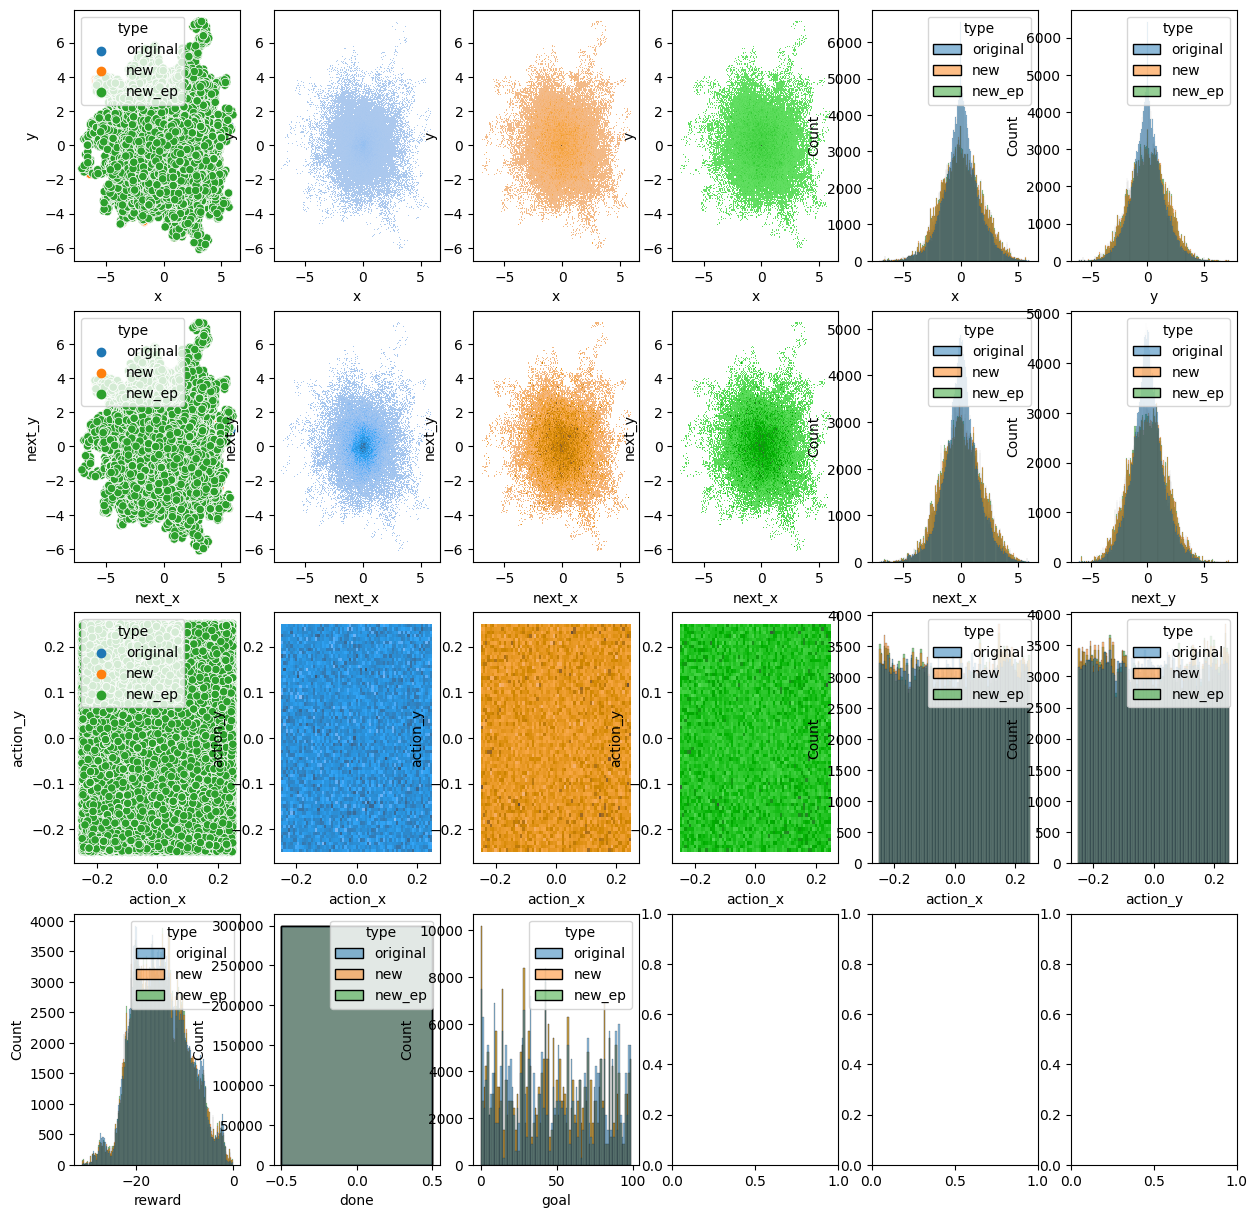

In [66]:
samples, goals = buffer.get_decoder_targets(np.random.choice(buffer.valid_indices(), 1000))
ep_idx = np.random.choice(new_buffer.valid_episodes, 1000)
sample_idx = np.random.randint(0, new_buffer.storage.episode_lengths[ep_idx], 1000)
new_samples = new_buffer.get_decoder_targets(ep_idx, sample_idx, num_targets=300, env=None)
new_buffer.random_normalization_mode = "uniform"
new_buffer.prepare_sampling(new_buffer.storage)
new_ep_samples = new_buffer.get_decoder_targets(ep_idx, sample_idx, num_targets=300, env=None)
new_buffer.decoder_context_mode = "random"

df_orginal = pd.DataFrame({
    "x": samples.observations.view(-1, 2)[:, 0].cpu(),
    "y": samples.observations.view(-1, 2)[:, 1].cpu(),
    "next_x": samples.next_observations.view(-1, 2)[:, 0].cpu(),
    "next_y": samples.next_observations.view(-1, 2)[:, 1].cpu(),
    "action_x": samples.actions.view(-1, 2)[:, 0].cpu(),
    "action_y": samples.actions.view(-1, 2)[:, 1].cpu(),
    "reward": samples.rewards.view(-1).cpu(),
    "done": samples.dones.view(-1).cpu(),
    "type": "original",
    "goal": goals.reshape(-1),
    "group": (np.arange(samples.actions.shape[0])[:, None] + np.zeros(samples.actions.shape[1])[None, :]).reshape(-1)
})
df_new = pd.DataFrame({
    "x": new_samples.observations["observation"].view(-1, 2)[:, 0].cpu(),
    "y": new_samples.observations["observation"].view(-1, 2)[:, 1].cpu(),
    "next_x": new_samples.next_observations["observation"].view(-1, 2)[:, 0].cpu(),
    "next_y": new_samples.next_observations["observation"].view(-1, 2)[:, 1].cpu(),
    "action_x": new_samples.actions.view(-1, 2)[:, 0].cpu(),
    "action_y": new_samples.actions.view(-1, 2)[:, 1].cpu(),
    "reward": new_samples.rewards.view(-1).cpu(),
    "done": new_samples.dones.view(-1).cpu(),
    "type": "new",
    "goal": new_samples.next_observations["goal_idx"].view(-1).cpu(),
    "group": (np.arange(samples.actions.shape[0])[:, None] + np.zeros(samples.actions.shape[1])[None, :]).reshape(-1)
})
df_new_ep = pd.DataFrame({
    "x": new_ep_samples.observations["observation"].view(-1, 2)[:, 0].cpu(),
    "y": new_ep_samples.observations["observation"].view(-1, 2)[:, 1].cpu(),
    "next_x": new_ep_samples.next_observations["observation"].view(-1, 2)[:, 0].cpu(),
    "next_y": new_ep_samples.next_observations["observation"].view(-1, 2)[:, 1].cpu(),
    "action_x": new_ep_samples.actions.view(-1, 2)[:, 0].cpu(),
    "action_y": new_ep_samples.actions.view(-1, 2)[:, 1].cpu(),
    "reward": new_ep_samples.rewards.view(-1).cpu(),
    "done": new_ep_samples.dones.view(-1).cpu(),
    "type": "new_ep",
    "goal": new_ep_samples.next_observations["goal_idx"].view(-1).cpu(),
    "group": (np.arange(samples.actions.shape[0])[:, None] + np.zeros(samples.actions.shape[1])[None, :]).reshape(-1)
})
df = pd.concat([df_orginal, df_new, df_new_ep])
df.reset_index(inplace=True)


fig, axs = plt.subplots(4, 6, figsize=(15, 15))

sns.scatterplot(data=df, x="x", y="y", hue="type", ax=axs[0, 0])
sns.histplot(data=df_orginal, x="x", y="y", ax=axs[0, 1])
sns.histplot(data=df_new, x="x", y="y", color="orange", ax=axs[0, 2])
sns.histplot(data=df_new_ep, x="x", y="y", color="green", ax=axs[0, 3])
sns.histplot(data=df, x="x", hue="type", ax=axs[0, 4])
sns.histplot(data=df, x="y", hue="type", ax=axs[0, 5])

sns.scatterplot(data=df, x="next_x", y="next_y", hue="type", ax=axs[1, 0])
sns.histplot(data=df_orginal, x="next_x", y="next_y", ax=axs[1, 1])
sns.histplot(data=df_new, x="next_x", y="next_y", color="orange", ax=axs[1, 2])
sns.histplot(data=df_new_ep, x="next_x", y="next_y", color="green", ax=axs[1, 3])
sns.histplot(data=df, x="next_x", hue="type", ax=axs[1, 4])
sns.histplot(data=df, x="next_y", hue="type", ax=axs[1, 5])

sns.scatterplot(data=df, x="action_x", y="action_y", hue="type", ax=axs[2, 0])
sns.histplot(data=df_orginal, x="action_x", y="action_y", ax=axs[2, 1])
sns.histplot(data=df_new, x="action_x", y="action_y", color="orange", ax=axs[2, 2])
sns.histplot(data=df_new_ep, x="action_x", y="action_y", color="green", ax=axs[2, 3])
sns.histplot(data=df, x="action_x", hue="type", ax=axs[2, 4])
sns.histplot(data=df, x="action_y", hue="type", ax=axs[2, 5])

sns.histplot(data=df, x="reward", hue="type", ax=axs[3, 0])
sns.histplot(data=df, x="done", hue="type", ax=axs[3, 1])
sns.histplot(data=df, x="goal", hue="type", ax=axs[3, 2])

<Axes: xlabel='reward', ylabel='Density'>

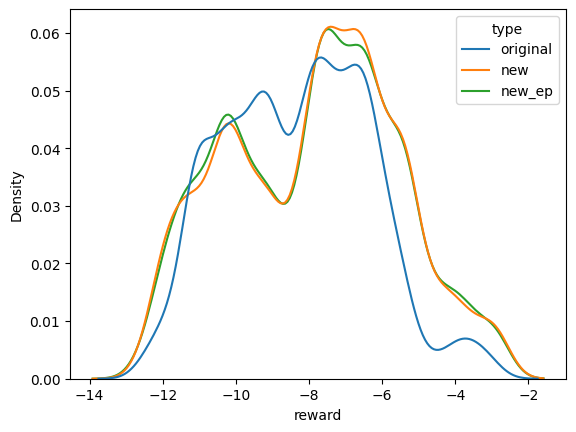

In [73]:
sns.kdeplot(data=df.where(df["goal"] == 15), x="reward", hue="type")

<Axes: xlabel='x', ylabel='y'>

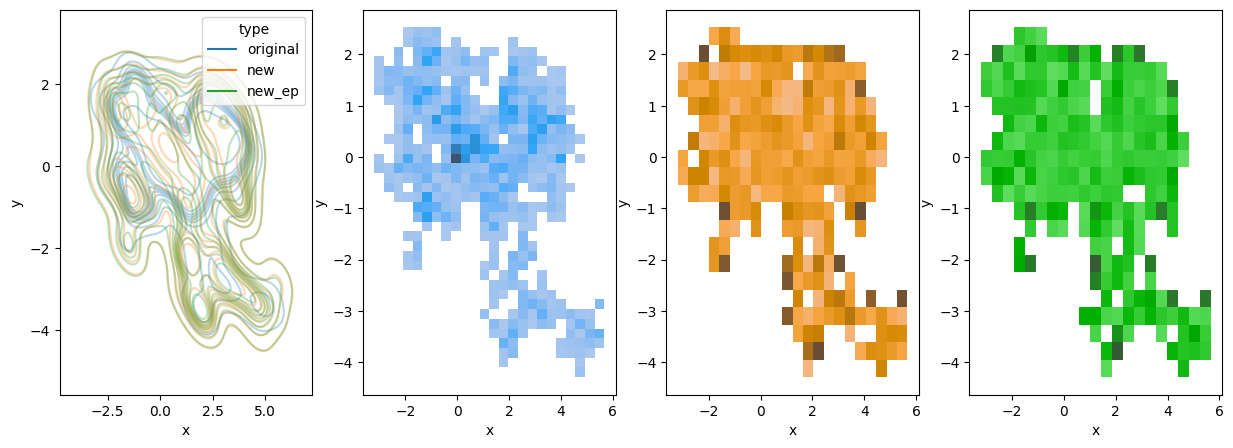

In [75]:
# goals = new_samples.next_observations["goal_idx"] == 15
# fig, ax = plt.subplots(1, 3)
# ax[0].hist2d(new_samples.observations["observation"][th.where(goals)[0], :, 0].view(-1).cpu().numpy(), new_samples.observations["observation"][th.where(goals)[0], :, 1].view(-1).cpu().numpy())
# goals_ep = new_ep_samples.next_observations["goal_idx"] == 15
# ax[1].hist2d(new_ep_samples.observations["observation"][th.where(goals_ep)[0], :, 0].view(-1).cpu().numpy(), new_ep_samples.observations["observation"][th.where(goals_ep)[0], :, 1].view(-1).cpu().numpy())
# plt.show()
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
sns.kdeplot(data=df.where(df["goal"] == 15), x="x", y="y", hue="type", ax=axs[0], alpha=0.3)
sns.histplot(data=df_orginal.where(df_orginal["goal"] == 15), x="x", y="y", ax=axs[1])
sns.histplot(data=df_new.where(df_new["goal"] == 15), x="x", y="y", color="orange", ax=axs[2])
sns.histplot(data=df_new_ep.where(df_new_ep["goal"] == 15), x="x", y="y", color="green", ax=axs[3])

<Axes: xlabel='x', ylabel='y'>

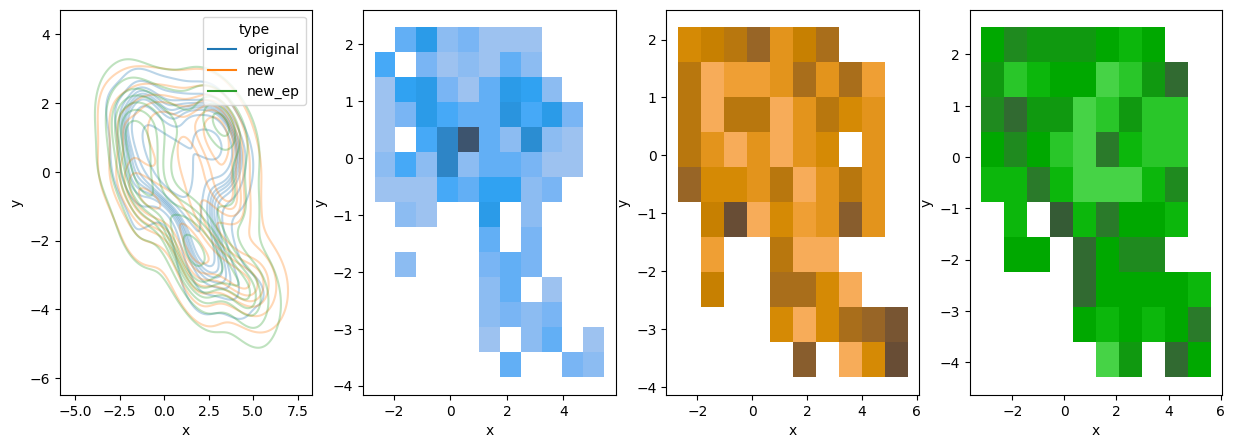

In [76]:
orginal_group = df_orginal[df_orginal["goal"] == 15]["group"].iloc[0]
new_group = df_new[df_new["goal"] == 15]["group"].iloc[0]
new_ep_group = df_new_ep[df_new_ep["goal"] == 15]["group"].iloc[0]

fig, axs = plt.subplots(1, 4, figsize=(15, 5))
df_tmp = pd.concat([df_orginal[df_orginal["group"] == orginal_group], df_new[df_new["group"] == new_group], df_new_ep[df_new_ep["group"] == new_ep_group]])
sns.kdeplot(data=df_tmp, x="x", y="y", hue="type", ax=axs[0], alpha=0.3)
sns.histplot(data=df_orginal.where(df_orginal["group"] == orginal_group), x="x", y="y", ax=axs[1])
sns.histplot(data=df_new.where(df_new["group"] == new_group), x="x", y="y", color="orange", ax=axs[2])
sns.histplot(data=df_new_ep.where(df_new_ep["group"] == new_ep_group), x="x", y="y", color="green", ax=axs[3])